# Audio Decomposition

In this homework we will explore NMF-based audio decomposition.

We are getting close to the final project, so I will be providing very little hand holding in this assignment.  I will simply give you broad tasks to accomplish without providing decomposed functions or answers.  It is up to you to verify that your code is working!

Please note that part of your grade will be on the readability and decomposition of your code, so make sure your code is clean and organized.  Part of your grade will also be on the clarity of your writing.  You should explain your thought process clearly and support your claims with appropriate plots.

Team member #1: Rafael Burger

Hours spent on hw: 6

Team member #2: Bob Zeng

Hours spent on hw: _____

In [534]:
%matplotlib inline

In [535]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.io as sio
import scipy.signal as spsig
import copy as cp
import soundfile as sf
from scipy.io.wavfile import write

### NMF (30 points)

In this section you will implement the NMF algorithm.  You should do the following:
- Calculate the STFT of the given audio file ('xylophone.mp3').
- Implement the NMF algorithm as described in class.
- Describe a suitable stopping criterion and justify your selection with logic and/or experimental plots.
- Run NMF on the magnitude STFT
- Visualize the estimated template and activation matrices.  Comment on the results.

In [536]:
### CALCULATE STFT OF AUDIO FILE

audio_file = 'xylophone.mp3'                                    # specify audio file
x, fs = lb.core.load(audio_file, sr = 22050)                    # unpack data from audio file

win_size = 1024                                                 # specify window size
hop_size = int(win_size / 2)                                    # specify hop size

f, t, S = spsig.stft(x, fs = fs, nperseg=win_size, noverlap=hop_size)

In [537]:
### STORE DIMENSIONS FOR LATER

K,M = S.shape               # define matrix dimensions
R = 8

In [538]:
### Implement NMF

epsilon = 10**-30

def updateH(V, W, H):
    H_1 = H * (W.T @ V) / ((W.T @ W @ H) + epsilon)
    return H_1

def updateW(V, W, H):
    W_1 = W * (V @ H.T) / ((W @ H @ H.T) + epsilon)
    return W_1

def NMF(V, W0, H0, num_iter):
    H_i = H0
    W_i = W0
    for i in range(num_iter):
        H_i = updateH(V = V, W = W_i, H = H_i)
        W_i = updateW(V, W = W_i, H = H_i)
    return (W_i, H_i)

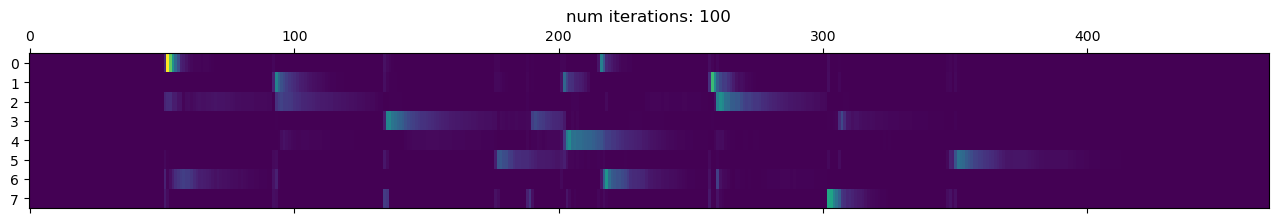

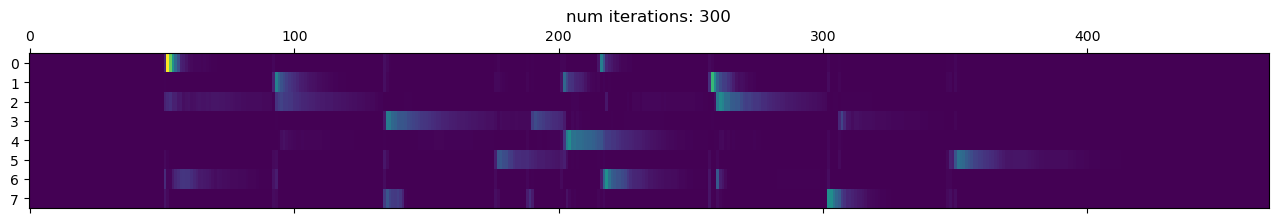

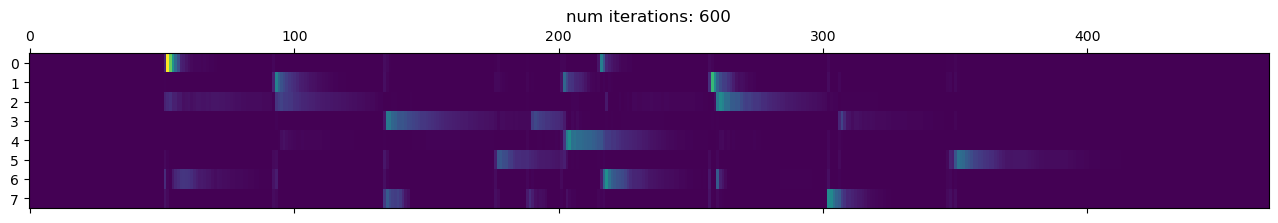

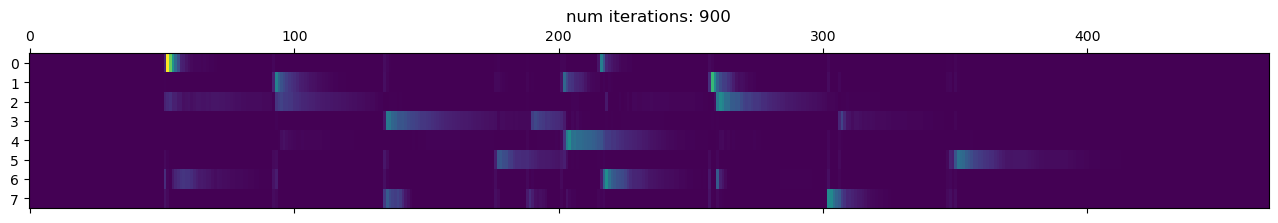

In [539]:
### Define function for determining valid stopping criteria 

def testNMF(V, W0, H0, iteration_list):
    for num_iter in iteration_list:
        W, H = NMF(V=V, W0=W0, H0=H0, num_iter=num_iter)
        plt.matshow(H, aspect = 'auto')
        plt.title("num iterations: %d" % num_iter)
        plt.show()


V = np.abs(S)
W1_init = np.random.random_sample((K,R))
H1_init = np.random.random_sample((R,M))

iters = np.array([100, 300, 600, 900])
testNMF(V=V, W0=W1_init, H0=H1_init, iteration_list = iters)


The above plots show that no change occurs within the gradient descent between 600 and 900 frames. For this reason, we feel that a conservative criterion for stopping is simply to run the NMF cycle for 1000 iterations. 

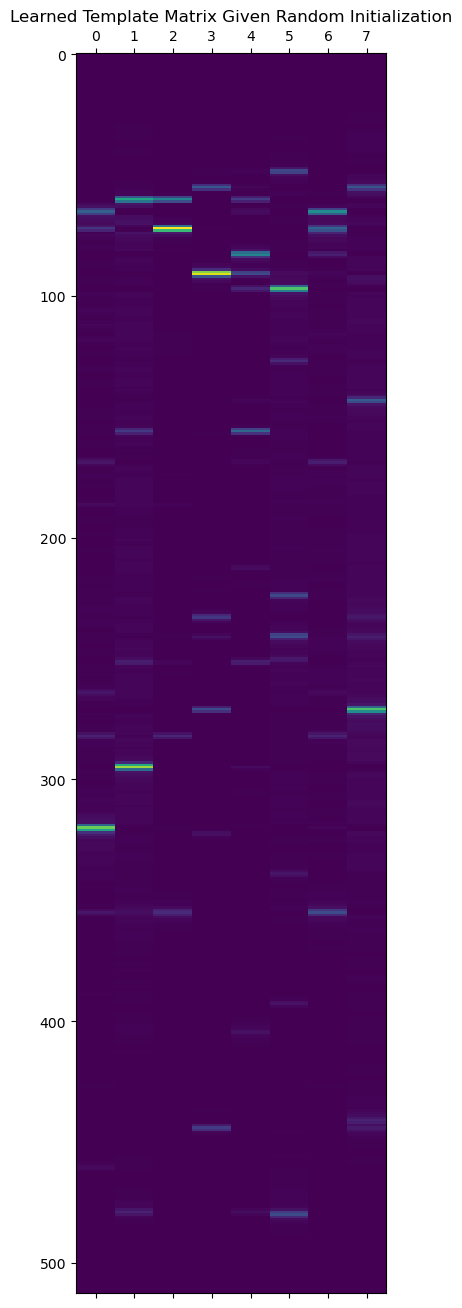

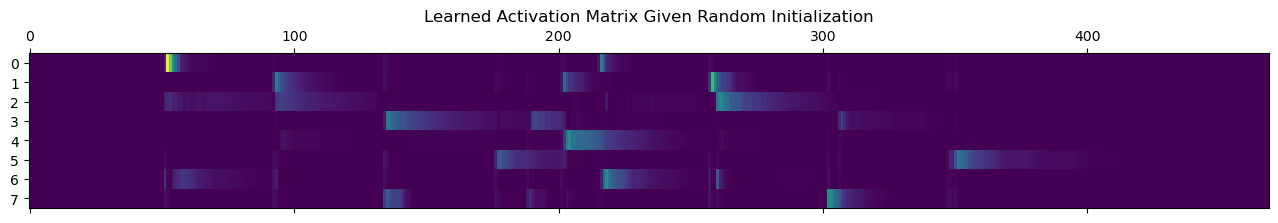

In [556]:
NUM_ITER = 1000

# RUN NMF ON INITIALIZED TEMPLATE AND ACTIVATION MATRICES
W1_learned, H1_learned = NMF(V = V, W0 = W1_init, H0 = H1_init, num_iter = NUM_ITER)

# VISUALIZE RESULTS
plt.matshow(W1_learned, aspect = 'auto')
plt.title("Learned Template Matrix Given Random Initialization")
plt.show()
plt.matshow(H1_learned, aspect = 'auto')
plt.title("Learned Activation Matrix Given Random Initialization")
plt.show()

These templates and activations have clearly diverged from the random initialization, but it is clear that the result they have converged upon does not correspond to individual notes. They have likely latched on to other features that are common between portions of the audio frame. I imagine that the reconstruction methods discussed in class would not successfully separate right and left side notes, because the templates here are not partitioned with respect to notes. 

### Reconstruction (15 points)

In this section you will reconstruct the audio for the estimated left and right hand tracks.  You should do the following:
- Implement the simple approach described in class
- Implement the soft masking approach described in class
- Listen to the results of both reconstruction methods.  Comment.

In [541]:
# Function to perform reconstruction using easy masks

def reconstructEasyMask(H, W, R, X):

    phase = np.angle(X)

    R, M = H.shape
    HL = cp.deepcopy(H)
    HR = cp.deepcopy(H)

    HL[0:int(R/2)-1, :] = 0
    HR[int(R/2):0, :] = 0

    WH_L = W @ HL
    WH_R = W @ HR

    X_L = WH_L * np.exp(1j * phase)
    X_R = WH_R * np.exp(1j * phase)

    _, x_L = spsig.istft(X_L, fs = fs, window='hann', nperseg=win_size, noverlap=hop_size)
    _, x_R = spsig.istft(X_R, fs = fs, window='hann', nperseg=win_size, noverlap=hop_size)

    return (x_L, x_R)


In [542]:
# reconstruct easy masks for naive initialization template and activation matrices
x1_L, x1_R = reconstructEasyMask(H1_learned, W1_learned, 8, S)

# save reconstructed audio data
sf.write("out1L_easy-mask.wav",x1_L,22050)
sf.write("out1R_easy-mask.wav",x1_R,22050)

In [543]:
# Function to perform reconstruction using soft masks

def reconstructSoftMask(H, W, R, X):

    epsilon = 10**-20

    R, M = H.shape

    HL = cp.deepcopy(H)
    HR = cp.deepcopy(H)

    HL[0:int(R/2)-1, :] = 0
    HR[int(R/2):0, :] = 0

    WH_L = W @ HL
    WH_R = W @ HR

    M_L = WH_L / (W @ H + epsilon)
    M_R = WH_R / (W @ H + epsilon)

    X_L = M_L * X
    X_R = M_R * X

    _, x_L = spsig.istft(X_L, fs = fs, window='hann', nperseg=win_size, noverlap=hop_size)
    _, x_R = spsig.istft(X_R, fs = fs, window='hann', nperseg=win_size, noverlap=hop_size)

    return (x_L, x_R)

In [544]:
# reconstruct soft masks for naive initialization template and activation matrices
x1_L_mask, x1_R_mask = reconstructSoftMask(H1_learned, W1_learned, R, S)

sf.write("out1L_soft-mask.wav",x1_L_mask,22050)
sf.write("out1R_soft-mask.wav",x1_R_mask,22050)

The reconstructed audio clearly resembles something similar to the input audio data, however it does not seem to have succeeded in separating the right and left half notes from each other. Both "right" and "left" side audio recordings clearly contain both high and low notes playing simultaneously. The two audio records are not identical, however, implying that information has been partitioned between the two recordings, except this information does not adhere to note templates and is more difficult to recognize under an obvious feature. 

### Initializing templates (15 points)

In this section you will initialize the templates to incorporate prior knowledge.  You should do the following:
- Create a function that initializes a template matrix given a set of midi note numbers.  The templates should have random positive values around harmonic frequencies (+/- half a semitone), and zeros elsewhere.
- Visualize the initialized template matrix using the notes {C6, D6, E6, F6, G6, A6, B6, C7}.
- Run NMF with the initialized template matrix
- Visualize the resulting template and activation matrices.  Comment.
- Sonify the left and right hand tracks.  Comment.

In [545]:
### Define Functions to help with W(0) initialization

# define helper function to convert frequency to corresponding frequency bin

ENSURE_NONZERO = 0.1 # add this to randomly generated quantities to ensure they are nonzero

def getFreqBin(f, N, fs):
    return int(f * N/ fs)

# define function to create column of W(0) for a given note frequency
def calcTemplate(f0, K, N = 1024, f_margin = 5, fs = 22050):

    init_val = 1 # initial value to populate nonzero entries with

    if f0 == 0: # percussive template case

        template = np.random.random_sample((K,)) + ENSURE_NONZERO # add 0.01 to avoid the possibility of a zero

    else: # note template case   

        template = np.zeros((K,))

        harmonic_num = 1
        f_i = f0
        f_low = f_i- harmonic_num * f_margin # create high and low boundaries to set nonzero to account for note tuning inaccuracies
        f_high = f_i + harmonic_num * f_margin
        k_low = getFreqBin(f_low, N=N, fs = fs)  # compute the STFT frequency bin indices corresponding to the low and high frequency limits
        k_high = getFreqBin(f_high, N=N, fs = fs)

        while k_low < K:    # as long as k_low in range, add the next harmonic 

            if k_low < 0: # account for case where k_low out of range but k_high in range
                k_low = 0

            if k_high >= K: # account for case where k_low is in range and k_high is out of range
                k_high = K-1

            if k_high - k_low < 1: ## account for case where k_high-k_low is too small to show up on matrix indices
                k_high = k_low + 1
            
            
            template[k_low:k_high] = np.random.random_sample((int(k_high-k_low),)) + ENSURE_NONZERO # assign initialization value to the frequency bins surrounding the current harmonic

            harmonic_num = harmonic_num + 1             # increment harmonic counter
            f_i = harmonic_num * f0                     # compute frequency of next harmonic
            f_low = f_i - harmonic_num * f_margin       # compute high and low error limits for new harmonic
            f_high = f_i + harmonic_num * f_margin
            k_low = getFreqBin(f_low, N=N, fs = fs)      # compute corresponding STFT frequency bin indices
            k_high = getFreqBin(f_high, N=N, fs = fs)
        
    return template

def calcTemplates(f0_list, K, R):
    W_init = np.zeros((K,R))
    for i in range(R):
        W_init[:,i] = calcTemplate(f0 = f0_list[i], K = K)
    return W_init

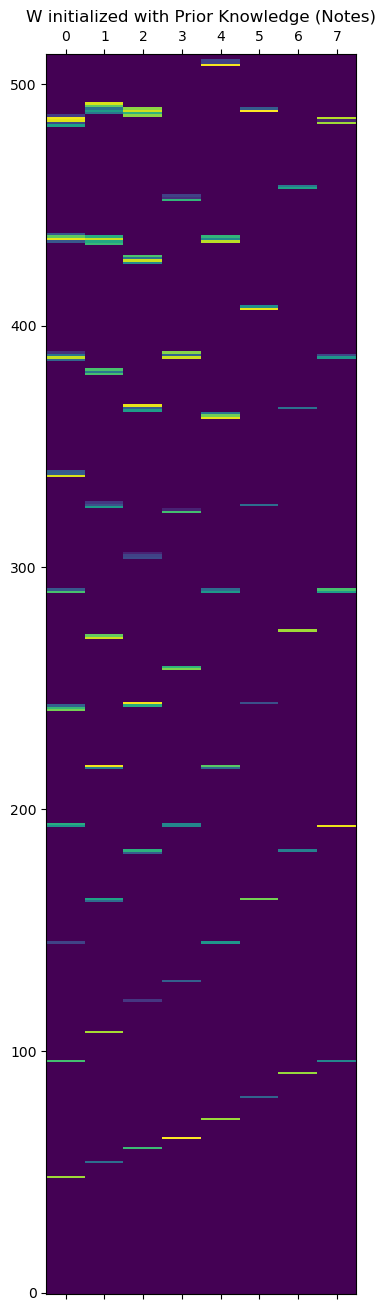

In [546]:
# define list of note frequencies [C4, D4, ... ,B4, C5]
f0_list = np.array([1046.5, 1174.66, 1318.51, 1396.91, 1567.98, 1760.00, 1975.53, 2093.00])

W2_init = calcTemplates(f0_list = f0_list, K = K, R = R)

plt.matshow(W2_init, aspect = 'auto', origin = 'lower')
plt.title("W initialized with Prior Knowledge (Notes)")
plt.show()

### Initializing Activations (10 points)

In this section you will initialize the activations to incorporate prior knowledge.  You may assume that you have already aligned the score and the audio, and have predicted the following note events at the following times.  You should do the following:
- Create a function that initializes an activation matrix given the note event information.  The entries should have random positive values around the note onsets, and zeros elsewhere.  You may assume a fixed note duration of 1 sec.
- Visualize the initialized activation matrix
- Run NMF with the initialized template and activation matrices
- Visualize the resulting template and activation matrices. Comment.
- Sonify the left and right hand tracks. Comment.

In [547]:
noteEvents = [(3, 1.23), (4, 1.23), (2, 2.19), (4, 2.19), (1, 3.16), (6, 3.16), 
              (0, 4.12), (7, 4.12), (1, 4.42), (6, 4.42), (2, 4.72), (5, 4.72),
              (3, 5.05), (4, 5.05), (2, 6.02), (4, 6.02), (1, 7.05), (6, 7.05),
              (0, 8.11), (7, 8.11)]

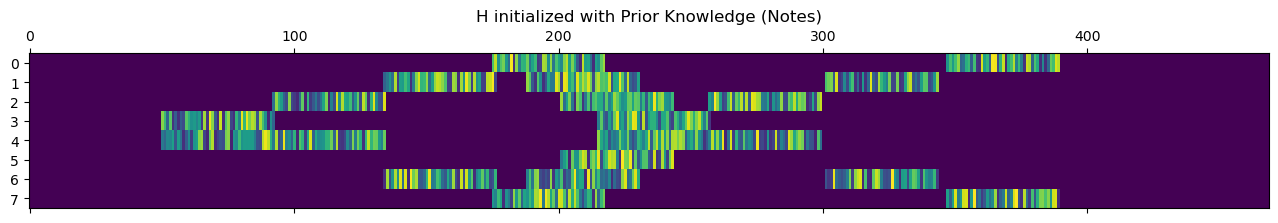

In [548]:
### INITIALIZE ACTIVATIONS TO INCORPORATE PRIOR KNOWLEDGE


def getAudioFrame(timestamp, fs, hop):
    audio_frame = timestamp * fs / hop
    return int(audio_frame)

def calcActivations(noteEvents, R, M):
    H_init = np.zeros((R, M))
    for i in range(len(noteEvents)):
        template = noteEvents[i][0]
        timestamp = noteEvents[i][1]
        audio_frame = getAudioFrame(timestamp = timestamp, fs = fs, hop = hop_size) - 2
        frame_duration = getAudioFrame(timestamp = 1, fs = fs, hop = hop_size)
        H_init[template, audio_frame:audio_frame+frame_duration] = np.random.random_sample(frame_duration) + ENSURE_NONZERO
    return H_init

H2_init = calcActivations(noteEvents = noteEvents, R = R, M = M)

plt.matshow(H2_init, aspect = 'auto')
plt.title("H initialized with Prior Knowledge (Notes)")
plt.show()

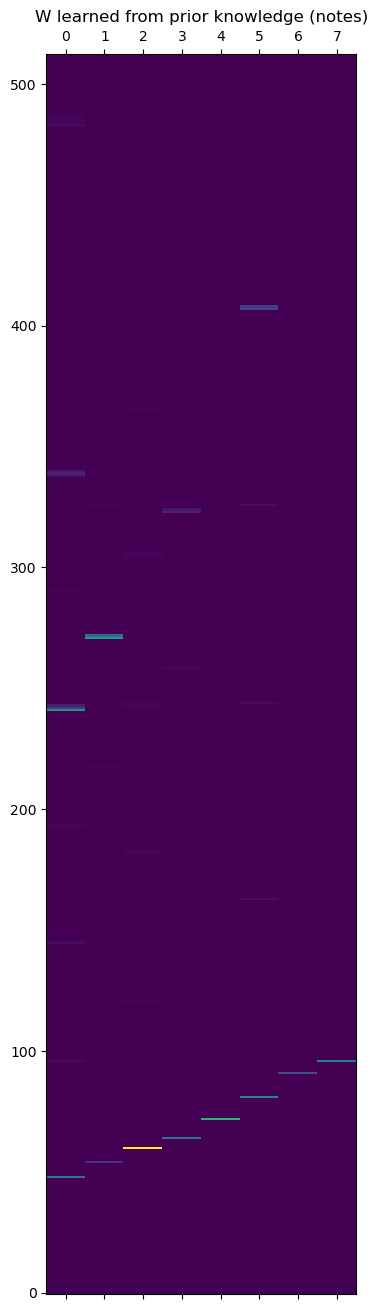

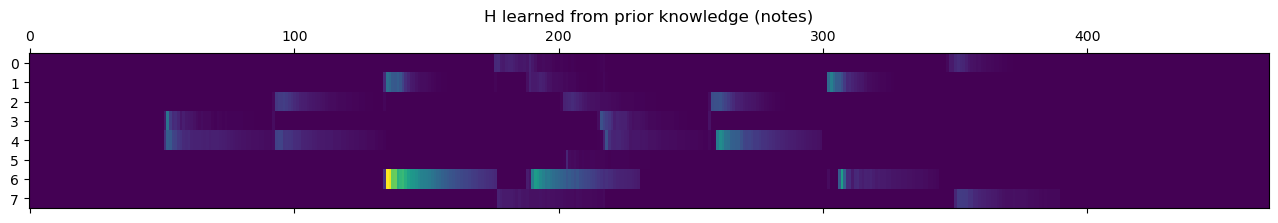

In [549]:
# Learn W and H from the second set of initializations (prior knowledge) and plot results

W2_learned, H2_learned = NMF(V = V, W0 = W2_init, H0 = H2_init, num_iter = NUM_ITER)
plt.matshow(W2_learned, aspect = 'auto', origin = "lower")
plt.title("W learned from prior knowledge (notes)")
plt.show()
plt.matshow(H2_learned, aspect = 'auto', origin = 'upper')
plt.title("H learned from prior knowledge (notes)")
plt.show()


The resulting template and activation matrices make sense given the context of the problem. The template matrix has converged upon a set of templates that correspond to the notes specified by the initialization matrix. This can be easily identified by the strong bands at the fundamental frequency of the natural notes C6 -> C7 towards the bottom of each template column. The templates show that little harmonic information is present in the recording. The activations matrix clearly shows a string of notes being played which correspond to the templates identified. 

In [550]:
# reconstruct from learned template and activation matrices (using soft masks)
x2_L_mask, x2_R_mask = reconstructSoftMask(H2_learned, W2_learned, 8, S)

# save data
sf.write("out2L_soft-mask.wav",x2_L_mask,22050)
sf.write("out2R_soft-mask.wav",x2_R_mask,22050)

The notes have clearly been separated into left and right models. One interesting observation I make is that the left recording seems to contain only (or mostly) harmonic content. By this I mean that the percussive starts to each note seem cut out of this recording. This effect makes it difficult to tell the recording is of a xylophone, though the melody is preserved. In the right side recording, the story is the same in that the harmonic content seems only to belong to that side of the xylophone, however this recording contains more percussive content. It seems that some of the right side templates must have picked up most of the percussive content and so separation siphons most of the percussion to the right side. 

### Onset Models (10 points)

In this section you will add onset models to your system.  You should do the following:
- Create a function that initializes a note & onset template matrix given a set of midi note numbers.  The note templates should have random positive values around harmonic frequencies, and zeros elsewhere.  The onset templates should have all random positive values.
- Create a function that initializes a note & onset activation matrix given the note event information.  The note activations should have random positive values for the interval (t_onset, t_onset+1.0), and zeros elsewhere.  The onset activations should have random positive values for the interval (t_onset - margin, t_onset + margin), and zeros elsewhere.
- Visualize the initialized template & activation matrices.
- Run NMF with the initialized template and activation matrices.
- Visualize the resulting template and activation matrices. Comment.
- Sonify the left and right hand tracks. Comment.

In [551]:
# We already have functionality built in to our existing function calcTemplate() to handle onsets, so we can reuse this function. 

# function to generate template matrix with onsets
def calcTemplatesWithOnsets(f0_list, K, R):
    W_init = np.zeros((K,int(R*2)))
    for i in range(int(R)):
        W_init[:,int(2*i)] = calcTemplate(f0 = f0_list[i], K = K)   # add template for the note i to column 2*i
        W_init[:,int(2*i+1)] = calcTemplate(f0 = 0, K = K)          # add corresponding onset template to column 2*i+1
    return W_init

In [552]:
# function to generate activation matrix with onsets
def calcActivationsWithOnsets(noteEvents, R, M):
    margin_frames = 2
    H_init = np.zeros((int(R*2), M))
    for i in range(len(noteEvents)):
        template = noteEvents[i][0]
        timestamp = noteEvents[i][1]
        audio_frame = getAudioFrame(timestamp = timestamp, fs = fs, hop = hop_size) - 2
        frame_duration = getAudioFrame(timestamp = 1, fs = fs, hop = hop_size)
        H_init[int(2*template), audio_frame:audio_frame+frame_duration] = np.random.random_sample(frame_duration) + ENSURE_NONZERO
        H_init[int(2*template+1), audio_frame-margin_frames:audio_frame+margin_frames] = np.random.random_sample(int(2*margin_frames)) + ENSURE_NONZERO
        
    return H_init

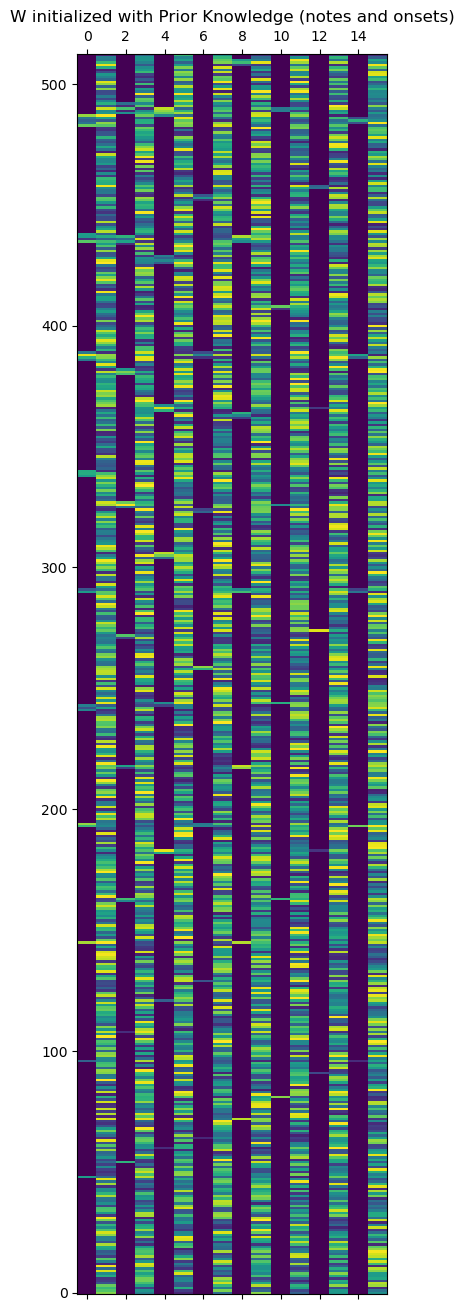

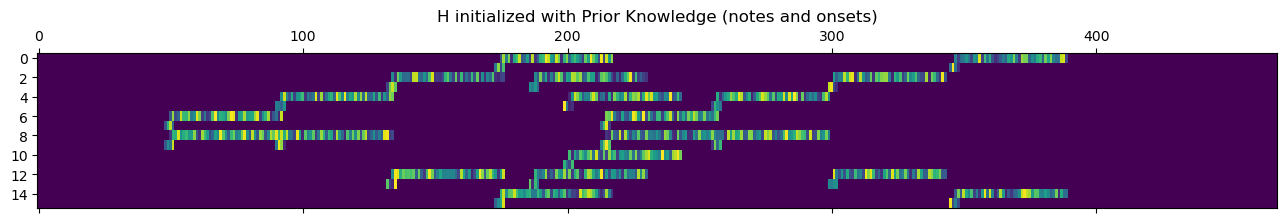

In [553]:
# initialize W with onsets
W3_init = calcTemplatesWithOnsets(f0_list, K, R)

# initialize H with onsets
H3_init = calcActivationsWithOnsets(noteEvents, R, M)

# visualize W and H with onsets
plt.matshow(W3_init, aspect = 'auto', origin = 'lower')
plt.title("W initialized with Prior Knowledge (notes and onsets)")
plt.show()

plt.matshow(H3_init, aspect = 'auto')
plt.title("H initialized with Prior Knowledge (notes and onsets)")
plt.show()

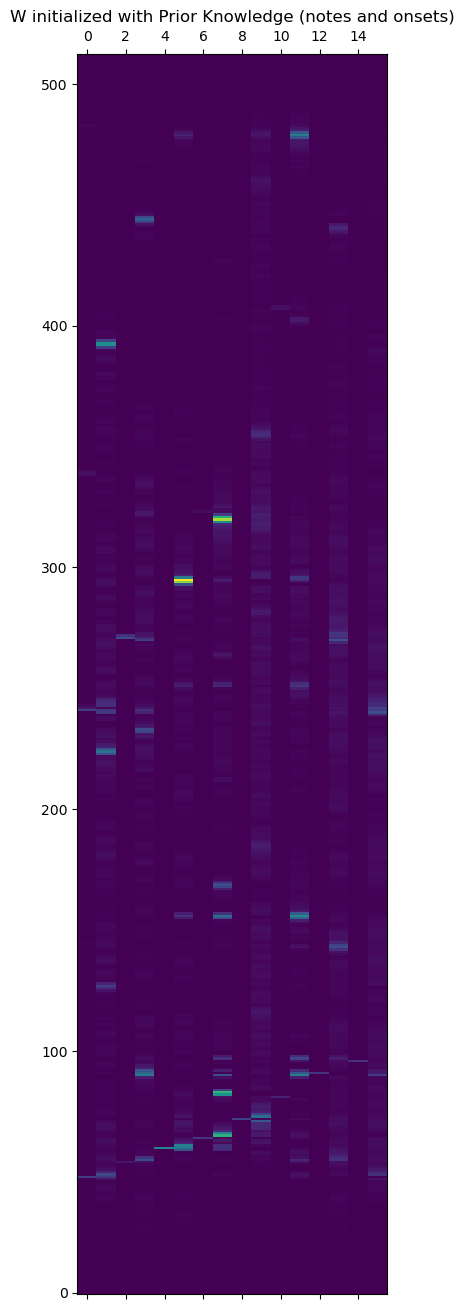

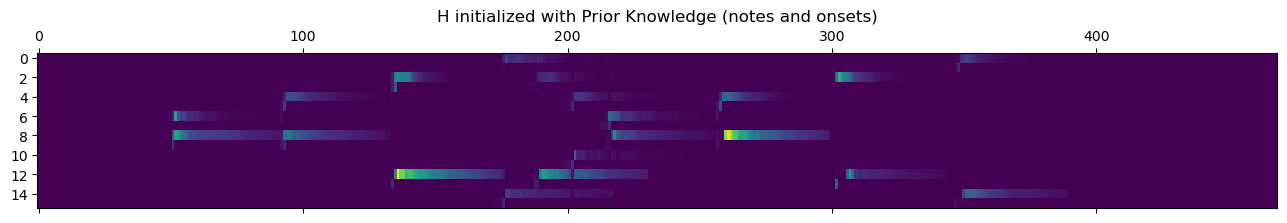

In [554]:
# RUN NMF ON TEMPLATE AND ACTIVATION MATRICES WITH ONSETS
W3_learned, H3_learned = NMF(V = V, W0 = W3_init, H0 = H3_init, num_iter = NUM_ITER)

# visualize learned W and H with onsets
plt.matshow(W3_learned, aspect = 'auto', origin = 'lower')
plt.title("W initialized with Prior Knowledge (notes and onsets)")
plt.show()

plt.matshow(H3_learned, aspect = 'auto')
plt.title("H initialized with Prior Knowledge (notes and onsets)")
plt.show()

These template and activation matrices seem similar to those seen in the previous part, with the only exception being the onset templates. The harmonic templates show the same pattern that reflects the notes C6->C7. The onset templates are interesting in that they are not all of equal magnitude. This might imply that some notes were hit harder or in a different way to produce a stronger onset compared to the other notes whose onset templates contain barely any information. The onsets in the activation matrix are what would be expected, with a note onset occuring at the very moment during which that note's harmonic content activates (for most cases). 

In [555]:
x3_L, x3_R = reconstructSoftMask(H = H3_learned, W = W3_learned, R = 16, X = S)

# save data
sf.write("out3L_soft-mask.wav",x3_L,22050)
sf.write("out3R_soft-mask.wav",x3_R,22050)

In this recording, percussive (onset) content seems more evenly distributed between the left and right recordings. The separation of left and right halves of the xylophone is not perfect -- in both recordings, the other side of the xylophone can still be faintly heard. Despite this, it seems that the left and right halves of the recording were separated fairly well. 